# **Use logistic regression to predict when employees are going to leave a company**

## 1. Data preprocessing (understanding of my data)

## 2. Data visualization (analyzing relationships between key variables)

## 3. Determine the causes for attrition by logistic regression

## 4. Assess the performance of my model

## 5. Generate 5 sample predictions for input values of my choosing


Author: Mia (Yuhsin Hou)

# Import necessary packages

In [0]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
from scipy import stats
from pylab import rcParams
from matplotlib.pyplot import MultipleLocator

rcParams['figure.figsize'] = (20, 8)
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from  sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import resample

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from patsy import dmatrices
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# **Part 1 - Data preprocessing (understanding of my data)**

## Load data

In [77]:
# Read data from Google Sheet
data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSed6JPpoDlhZjvLqwi_GH6zvhWrpcDi2YeHaXk7sNUjEEGfTNvslz7FhBSlfhvG5yQ-jpXLZoNoFmU/pub?gid=785624697&single=true&output=csv"
attrition_df = pd.read_csv(data_path)
attrition_df.head(3)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,0,HR,SMALL
2,0.54,0.81,4,257,2,0,0,0,ADMIN,SMALL


## Interpret data

In [78]:
list(attrition_df)

['employee_satisfaction',
 'last_performance_rating',
 'workload',
 'avg_montly_hours',
 'tenure_years',
 'ergo_issues',
 'attrit',
 'promo_in_last_5_years',
 'dept',
 'salary']

In [79]:
attrition_df.shape

(11249, 10)

The data contains 11,249 employees and 10 features.

## Feature difinition

It is pretty straightforward. 

Each row represents an employee, each column contains employee attributes.

Here's my interpretation:

- employee_satisfaction: the results vary from 0 to 1 where a higher score indicates a more satisfied employee. 
- last_performance_rating: last evaluation of the employee's performance, rating from 0 to 1. 
- workload: the amount of work ranging from 0 to 10. 
- avg_montly_hours: average monthly hours at workplace
- tenure_years: time spent at the company in years.
- ergo_issues: whether the employee had a workplace ergo issue. 1 means yes, 0 means no.
- attrit: whether the employee left the company or not. 1 means yes, 0 means no.
- promo_in_last_5_years: whether the employee was promoted in the last five years. 1 means yes, 0 means no.
- dept: department in which they work for. 
- salary: relative level of salary.


## The type of the columns can be found out as follows:

In [80]:
attrition_df.dtypes

employee_satisfaction      float64
last_performance_rating    float64
workload                     int64
avg_montly_hours             int64
tenure_years                 int64
ergo_issues                  int64
attrit                       int64
promo_in_last_5_years        int64
dept                        object
salary                      object
dtype: object

We can see we have 2 categorical variables: dept and salary. 

## Summary of descriptive statistics

In [81]:
attrition_df.describe().round(3)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years
count,11249.000,11249.000,11249.000,11249.000,11249.00,11249.000,11249.000,11249.000
mean,0.613,0.716,3.800,201.177,3.50,0.145,0.240,0.022
std,0.248,0.171,1.232,50.058,1.47,0.352,0.427,0.146
min,0.090,0.360,2.000,96.000,2.00,0.000,0.000,0.000
25%,0.440,0.560,3.000,156.000,3.00,0.000,0.000,0.000
50%,0.640,0.720,4.000,201.000,3.00,0.000,0.000,0.000
75%,0.820,0.870,5.000,245.000,4.00,0.000,0.000,0.000
max,1.000,1.000,7.000,310.000,10.00,1.000,1.000,1.000


The descriptive statistics of each feature are shown in above table. 

The range of each variable is reasonable, which is consistent with the actual environment in real world. 

Since the data quality is very high, we do not need data cleanning. 

## Identify missing value

In [82]:
# Check if there are missing values and the data type of each features.
total = attrition_df.isnull().sum().sort_values(ascending = False)
frame = [total]
missing_df = pd.concat(frame, axis=1, keys = ['Total'])
missing_df

,Total
salary,0
dept,0
promo_in_last_5_years,0
attrit,0
ergo_issues,0
tenure_years,0
avg_montly_hours,0
workload,0
last_performance_rating,0
employee_satisfaction,0


Our data is pretty clean, no missing values!

# **Part 2 - Data visualization (analyzing relationships between key variables)**

## First of all, I want to find out the number of employees who left the company and those who didn't. So review the attrit variable:   

In [83]:
# Count unique values in 'attrit'.
count = attrition_df['attrit'].value_counts()

# Compute the percentage of unique values in 'attrit'.
percent = (attrition_df['attrit'].value_counts() / attrition_df['attrit'].count() *100).round(2)

# Create a summary dataframe
frames = [count, percent]
attrit_agg = pd.concat(frames, axis=1, keys = ['Count', 'Percent'])
attrit_agg

,Count,Percent
0,8554,76.04
1,2695,23.96


We can see there are 2,695 employees left and 8,554 employees stayed in our data. 

The overall attrition rate of this company is 23.96%.

## Make a pie chart to visualize it

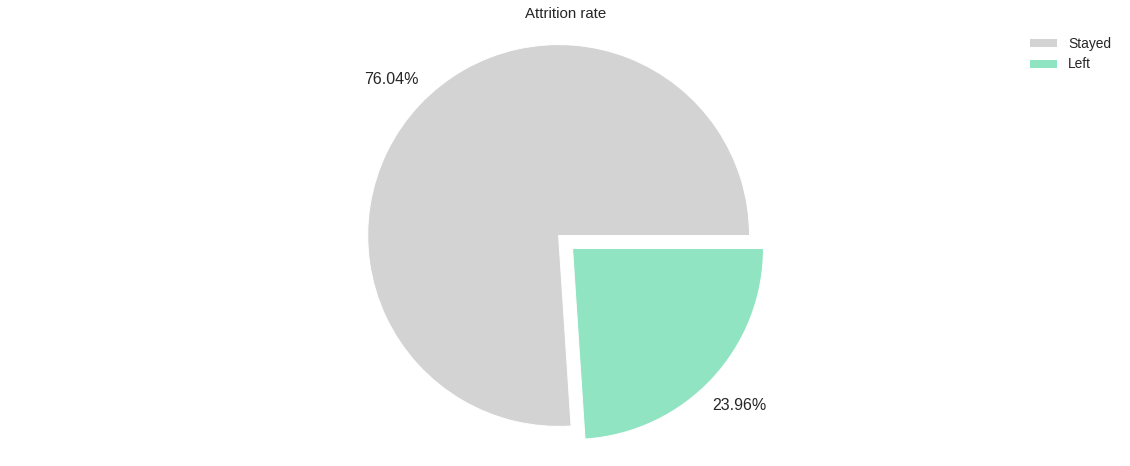

In [84]:
fig, ax = plt.subplots()
plt.rcParams['font.size']=16

color_palette_list = ['lightgrey', '#90e4c1']

percentages = percent.values.tolist()
explode=(0.1, 0)
labels = ['Stayed', 'Left']
ax.pie(percentages, colors = color_palette_list[0:2], autopct = '%1.2f%%', explode=explode, shadow = False, startangle = 0, pctdistance = 1.2, labeldistance = 1.4)
ax.axis('equal')
ax.set_title('Attrition rate')
ax.legend(labels)

Obviously, we are dealing with inbalanced dataset. 

## Calculate categorical means for each categorical variables

## Department:

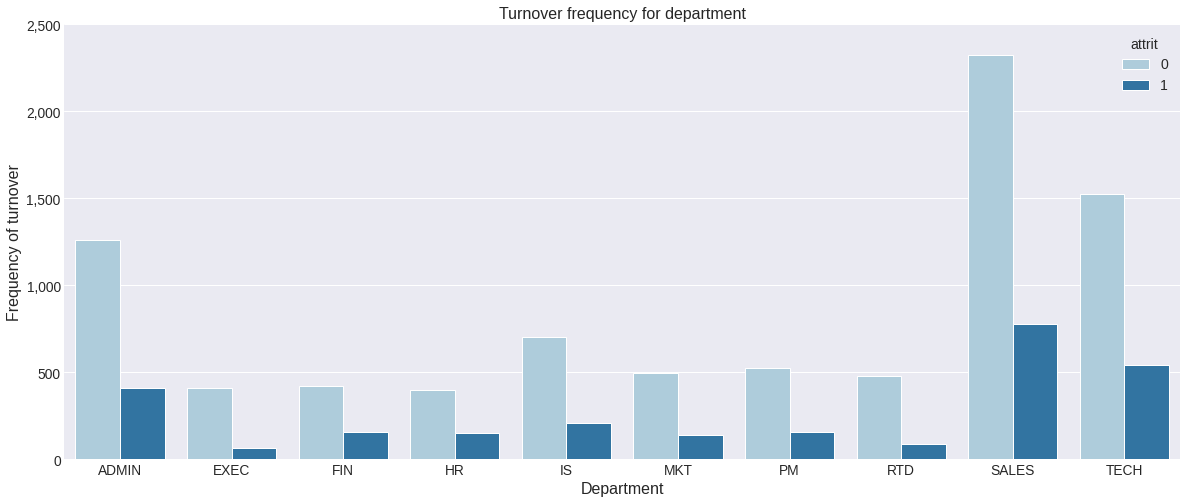

In [85]:
# Make a barplot
df = pd.DataFrame({'dept': attrition_df['attrit'], 'attrit': attrition_df['attrit']})
ct = pd.crosstab(attrition_df.dept, attrition_df.attrit)

stacked = ct.stack().reset_index().rename(columns={0:'value'})
ax = sns.barplot(x = stacked.dept, y = stacked.value, hue = stacked.attrit, palette = sns.color_palette('Paired'))

# Set x and y lable name and the title.
ax.set_xlabel('Department', fontsize = 16)
ax.set_ylabel('Frequency of turnover', fontsize = 16)
ax.set_title('Turnover frequency for department', fontsize = 16)

# Set the range for y axis. 
plt.ylim([0, 2500])

# Set font size for legend text and title.
plt.setp(ax.get_legend().get_texts(), fontsize='14') 
plt.setp(ax.get_legend().get_title(), fontsize='14')

# Format axes
fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

# # Set legend format 
# labels = ['left', 'stayed']
# plt.legend(bbox_to_anchor=(1,1), loc='center left', labels = labels)

In [86]:
attrition_df[['dept', 'attrit']].groupby(['dept'], as_index = False).mean().sort_values(by = 'attrit', ascending = False)

,dept,attrit
3,HR,0.277477
2,FIN,0.267703
9,TECH,0.261732
8,SALES,0.250484
0,ADMIN,0.246117
6,PM,0.227273
4,IS,0.226125
5,MKT,0.222920
7,RTD,0.157618
1,EXEC,0.134737


We can see that RTD and EXEC deptartments seem to experience the least turnover, while the other departments have similar turnover rates. 

## Salary level:

(0.0, 1.0)

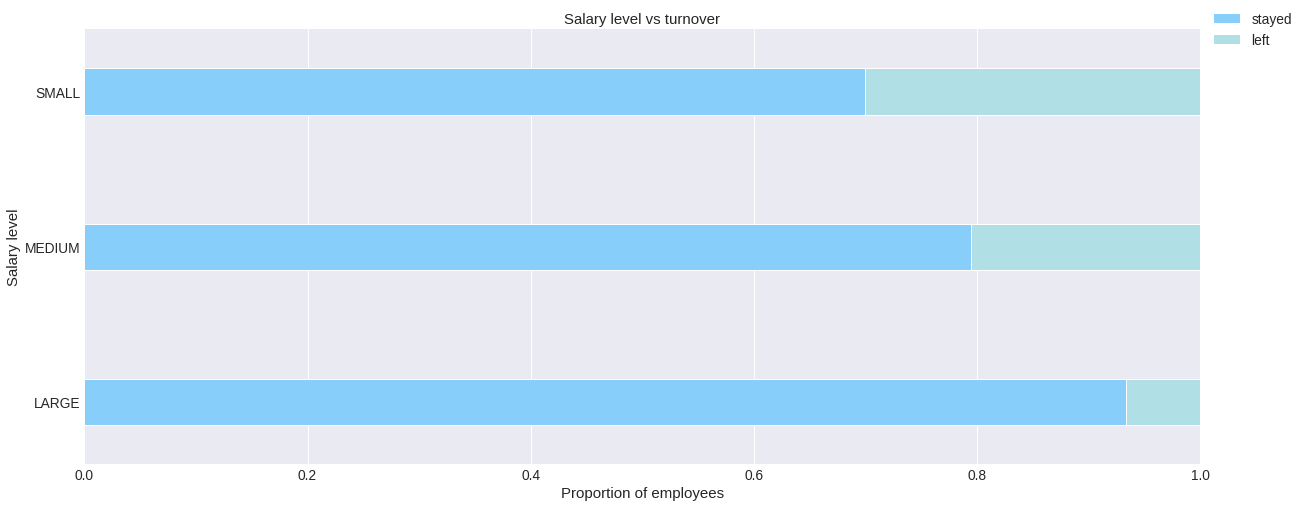

In [87]:
# Make a stackedplot
table = pd.crosstab(attrition_df.salary, attrition_df.attrit)
proportion = table.div(table.sum(1).astype(float), axis = 0)
proportion.plot.barh(stacked = True, color = ['lightskyblue', 'powderblue'], width = 0.3, legend = True)
plt.title('Salary level vs turnover')
plt.xlabel('Proportion of employees')
plt.ylabel('Salary level')

# Set legend format 
labels = ['stayed', 'left']
plt.legend(bbox_to_anchor=(1,1), loc='center left', labels = labels)

# Set the range for x axis. 
plt.xlim([0, 1])

As expected, salary is correlated with how likely someone will leave.

Employees who received small salary level left the company most. 

## Visualize the clear relationships between key quantitative variables and attrition

Before identifying what the key variables are, I want to get a sense of the numbers across 2 classes in attrit variable.

In [88]:
attrition_df.groupby('attrit').mean()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years
attrit,,,,,,,
0,0.667108,0.715087,3.779635,198.999766,3.379238,0.175473,0.027473
1,0.441080,0.719837,3.863451,208.086456,3.881633,0.048237,0.004082


,attrit
attrit,1.000
tenure_years,0.274
avg_montly_hours,0.054
last_performance_rating,0.002
workload,-0.014
promo_in_last_5_years,-0.068
ergo_issues,-0.154
employee_satisfaction,-0.365


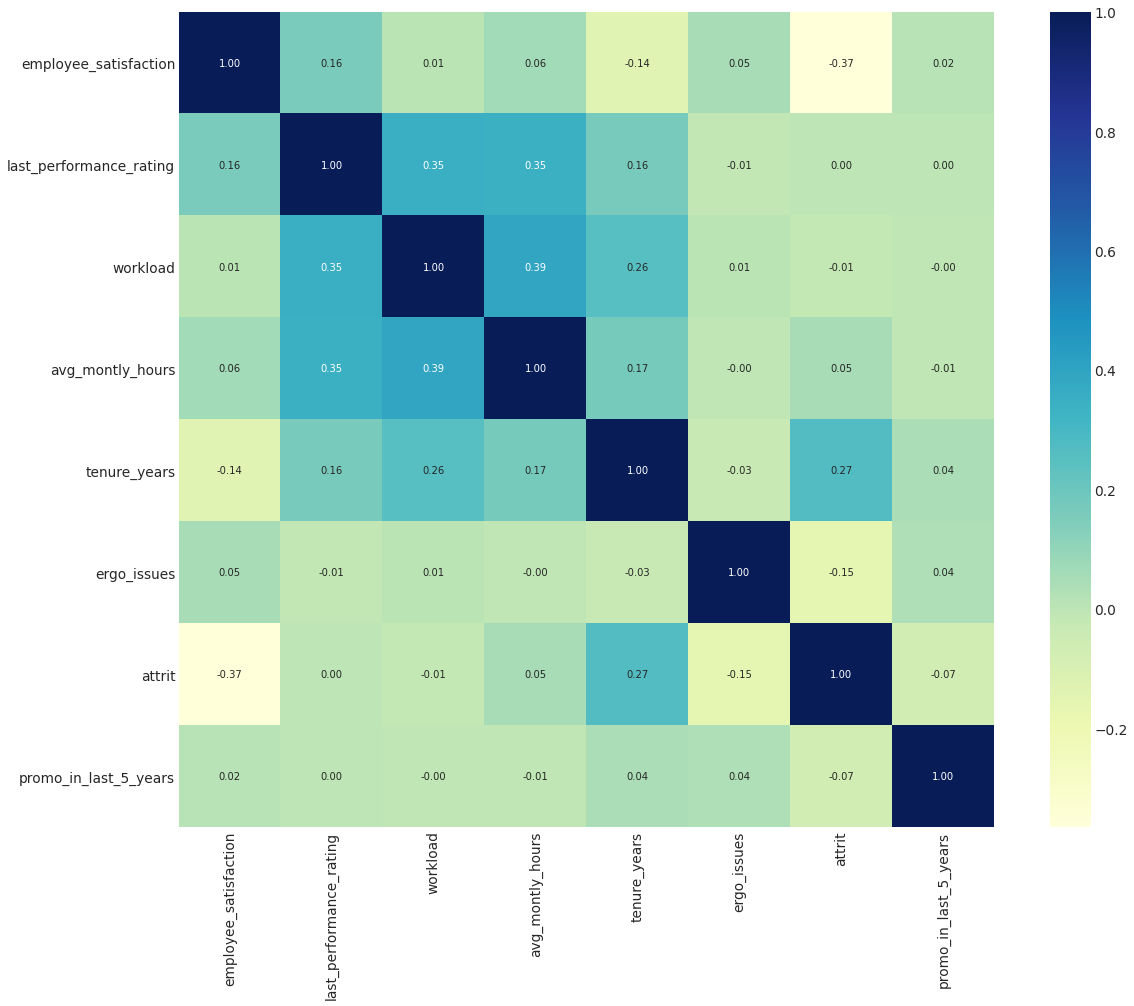

In [89]:
# Compute correlation matrix. 
corrmatrix = attrition_df.corr('spearman')

plt.rcParams['figure.figsize'] = (20, 15)
hm = sns.heatmap(corrmatrix, square = True, annot = True, cmap = 'YlGnBu', fmt = '.2f', annot_kws = {'size':10})
sns.set(font_scale=1.25)

# Print a dataframe to see how much each variable correlates with SalePrice.
corrmatrix['attrit'].sort_values(ascending=False).round(3).head(10).to_frame()

My observations:

- The average satisfaction level of employees who stayed with the company is higher than that of the employees who left, with the average score 0.67 v.s. 0.44.
- Employees who left the company have worked average 9 hours monthly more than that of the employees who stayed.
- It's surprising that the employees who had workplace ergo issues are less likely to leave than that of the employee who did not have workplace ergo issues.
- The employees who were promoted in the last 5 years are less likely to leave than those who did not get a promotion in the last five years.
- Given that both the workload feature and avg montly hours feature exhibit similar pattern, I will only visualize the worload one for simplicity.

I will visualize my data to get much clearer picture of the significant features and attrition. 


## 1. Emlpoyee satisfaction and attrition rate 

Text(0.5, 1.0, 'Turnover frequency for emlpoyee satisfaction')

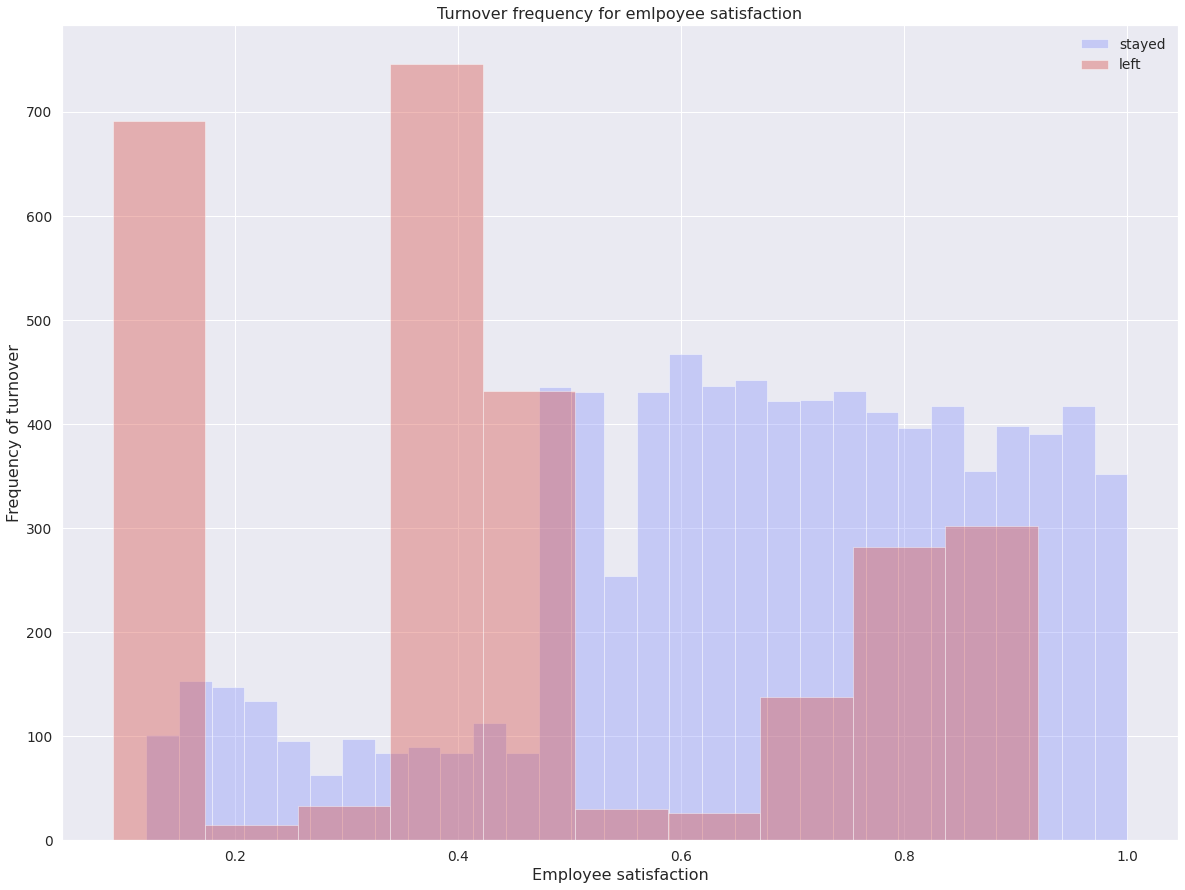

In [90]:
satis_stayed = attrition_df['employee_satisfaction'].loc[attrition_df['attrit'] == 0]
satis_left = attrition_df['employee_satisfaction'].loc[attrition_df['attrit'] == 1]

# Plot displot to see the frequency of attrion across in employee satisfaction. 
ax = sns.distplot(satis_stayed, hist = True, color = '#8f99fb', kde = False)
ax = sns.distplot(satis_left, hist = True, color = '#d9544d', kde = False) 
plt.legend(['stayed', 'left'])

# Set x and y lable name and the title.
ax.set_xlabel('Employee satisfaction', fontsize = 16)
ax.set_ylabel('Frequency of turnover', fontsize = 16)
ax.set_title('Turnover frequency for emlpoyee satisfaction', fontsize = 16)

Low satisfaction levels are associated with high attrition frequency, as expected.



## 2. Last performance rating and attrition

Text(0.5, 1.0, 'Turnover frequency for last performance rating')

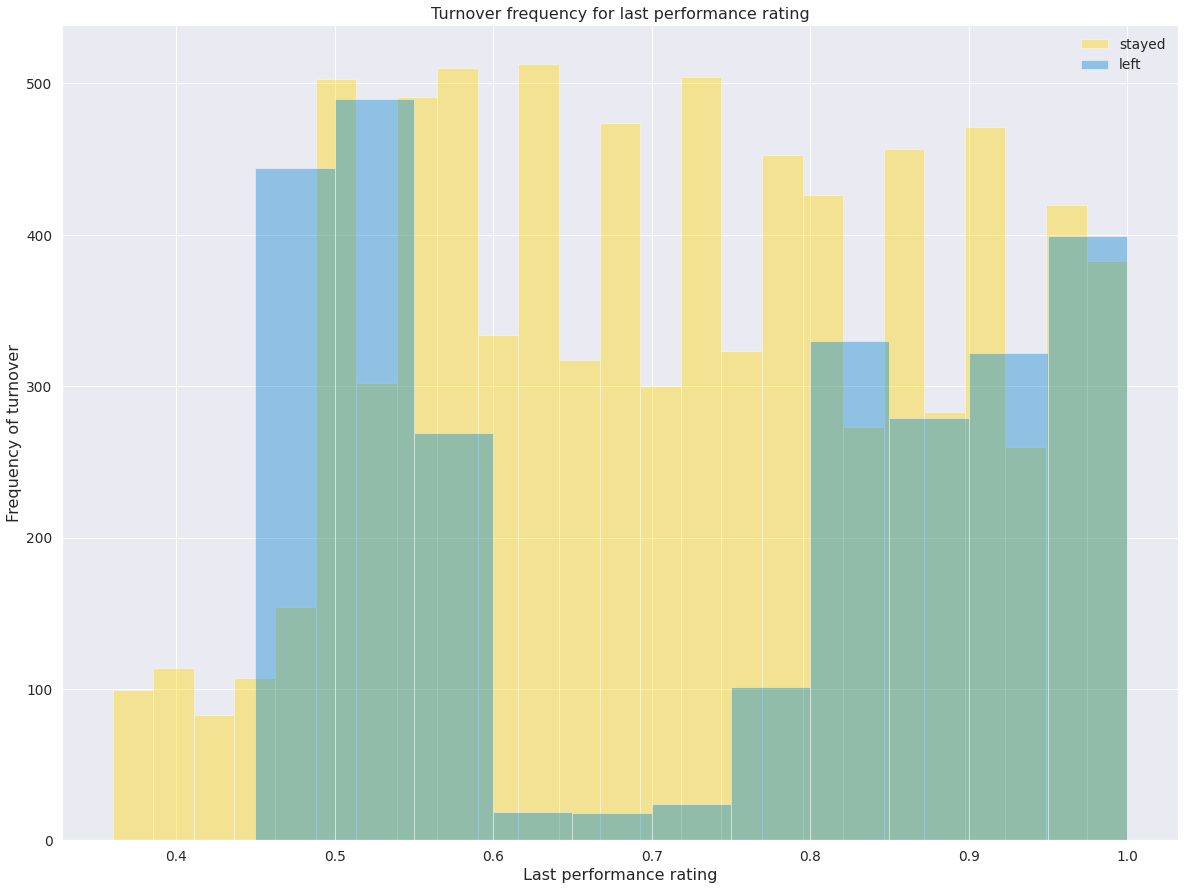

In [91]:
last_perf_rating_stayed = attrition_df['last_performance_rating'].loc[attrition_df['attrit'] == 0]
last_perf_rating_left = attrition_df['last_performance_rating'].loc[attrition_df['attrit'] == 1]

ax = sns.distplot(last_perf_rating_stayed, hist = True, color = 'gold', kde = False)
ax = sns.distplot(last_perf_rating_left, hist = True, color = '#0485d1', kde = False) 
plt.legend(['stayed', 'left'])

# Set x and y lable name and the title.
ax.set_xlabel('Last performance rating', fontsize = 16)
ax.set_ylabel('Frequency of turnover', fontsize = 16)
ax.set_title('Turnover frequency for last performance rating', fontsize = 16)

Employees who leave tend to either have received low scores (0.6 and below) or very high scores (0.8 and above). 

Employees last performaing rating in the middle rarely left.

## 3. Average montly hours and attrition

Text(0.5, 1.0, 'Relationship between average monthly hours and attriton')

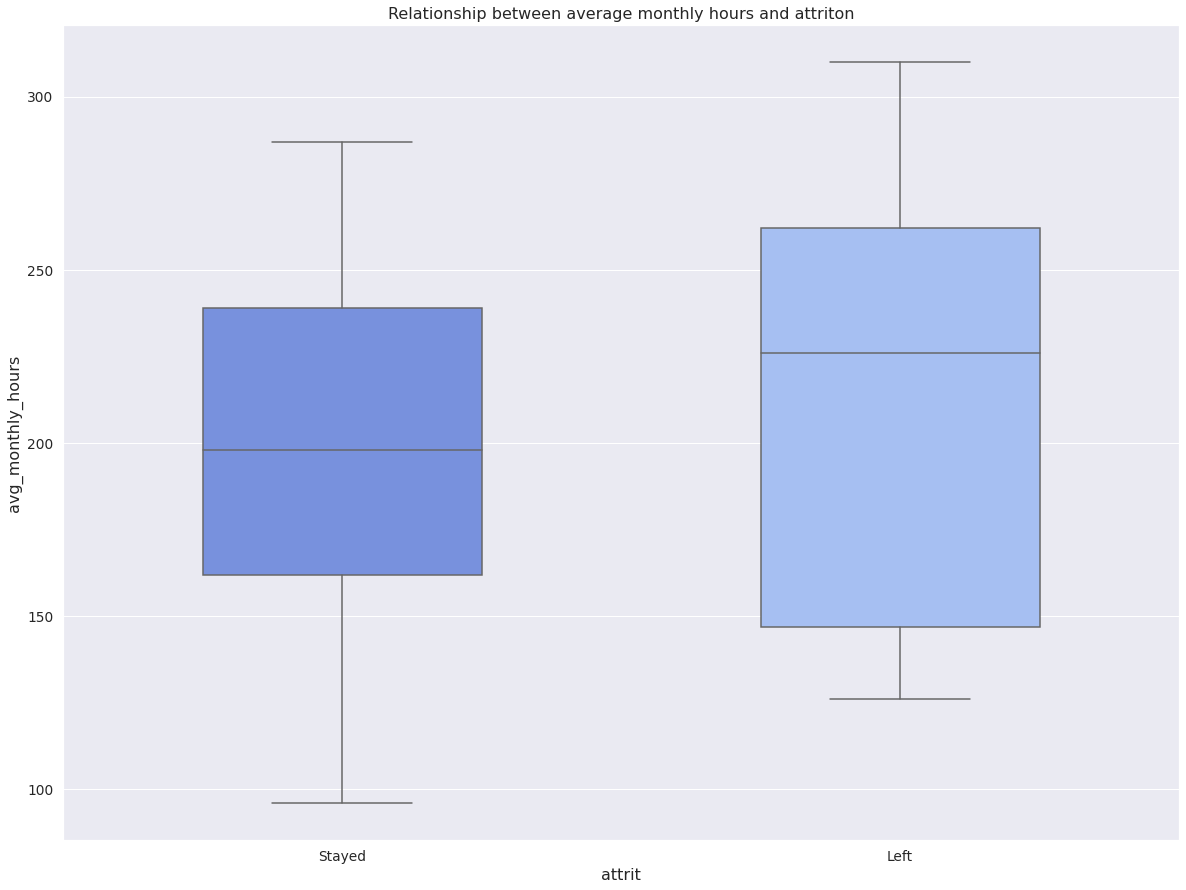

In [92]:
# Concatenate the columns of attrit and tenure_years. 
concat_ave_monthly_hours_attrit = pd.concat([attrition_df['attrit'], attrition_df['avg_montly_hours']], axis=1)

# Make a boxplot.
ax = sns.boxplot(x='attrit', y='avg_montly_hours', data = concat_ave_monthly_hours_attrit, palette = sns.color_palette('coolwarm'), showfliers = False, width = 0.5)
plt.xticks((0, 1), ['Stayed', "Left"])

# Set x and y lable name and the title.
ax.set_xlabel('attrit', fontsize = 16)
ax.set_ylabel('avg_monthly_hours', fontsize = 16)
ax.set_title('Relationship between average monthly hours and attriton', fontsize = 16)

The chart above compares the average monthly working hours of employees in 2 groups of employees who left and stayed in company.

The overall of employees left is higher than that of employees stayed in. 

The median average working hours of left employees is around 225 hours, which is around 11% higher than the 198 hours of stayed employees. 

If we based on 22 working days per month, the employees who left company have worked more 10 hours per day on average than the employees who stayed, which means the work intensity is relatively high. 

## 4. Tenure years and attrition 

([<matplotlib.axis.XTick at 0x7f55fa203b70>,
 [Text(0, 0, 'Stayed'), Text(0, 0, 'Left')])

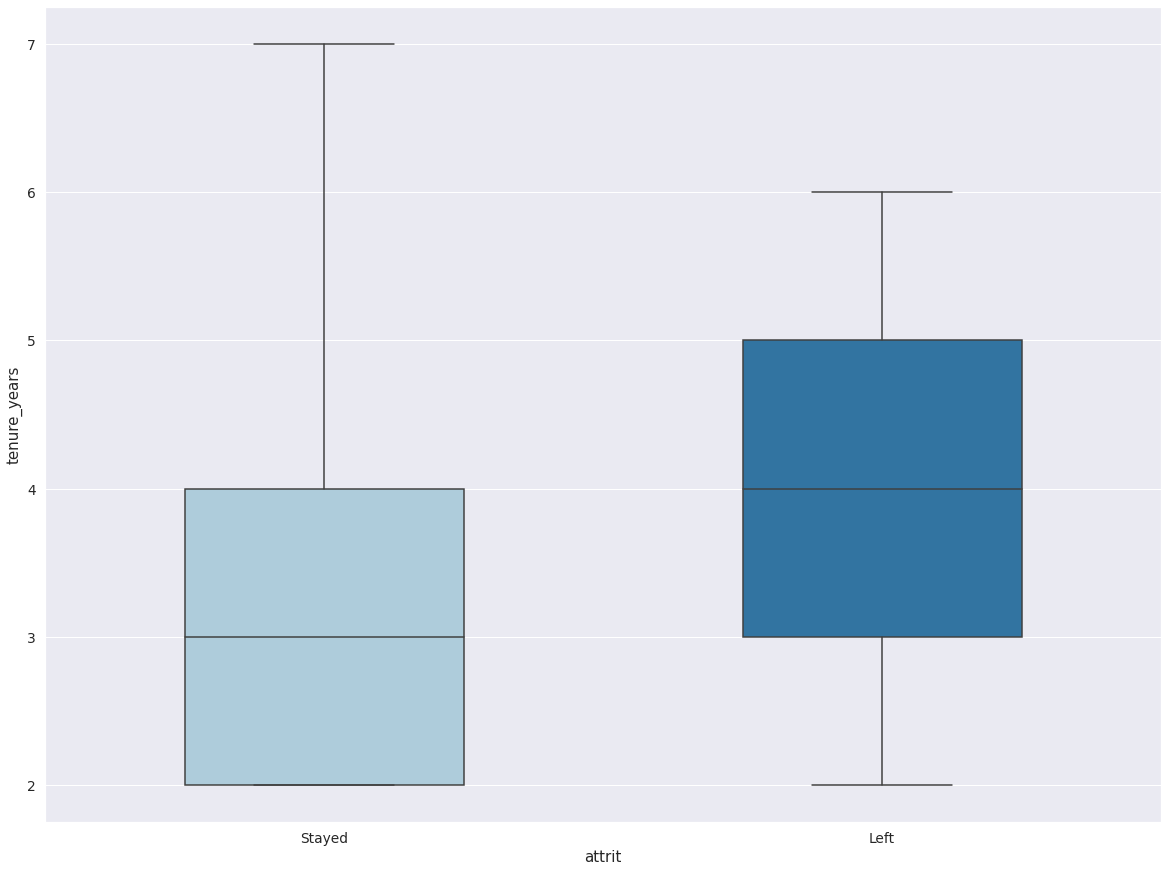

In [93]:
# Concatenate the columns of attrit and tenure_years. 
concat_tenure_attrit = pd.concat([attrition_df['attrit'], attrition_df['tenure_years']], axis=1)

# Make a boxplot.
ax = sns.boxplot(x='attrit', y='tenure_years', data = concat_tenure_attrit, palette = sns.color_palette('Paired'), showfliers = False, width = 0.5)

plt.xticks((0, 1), ['Stayed', "Left"])

- The turnover mainly focuses on employees with a working period of 3 to 5 years. 

- The turnover rate of new employees who worked for 2 years is very low.

- Worked above 6 years of employees have a turnover rate of zero. It indicates  a large part of the attrition belong to the profound experienced employees in the company.

## 5. Ergo issues and attrition 

([<matplotlib.axis.XTick at 0x7f55f8381d68>,
 [Text(0, 0, 'Had ergo issues'), Text(0, 0, 'Did not have ergo issues')])

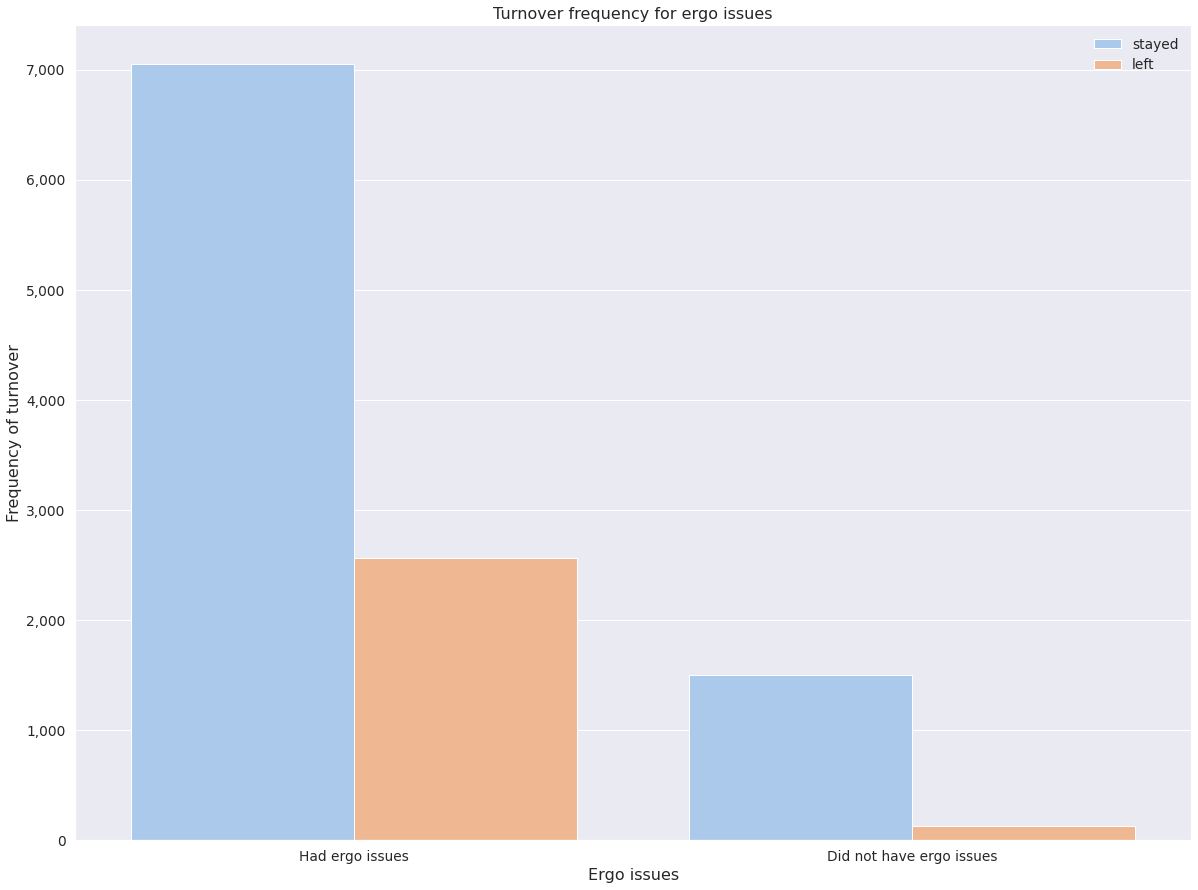

In [94]:
# Make a countplot.
ax = sns.countplot(x = 'ergo_issues', hue = 'attrit', data = attrition_df, palette = sns.color_palette('pastel'))

# Format legend.
plt.legend(['stayed', 'left'])

# Format axes
fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

# Set x and y lable name and the title.
ax.set_xlabel('Ergo issues', fontsize = 16)
ax.set_ylabel('Frequency of turnover', fontsize = 16)
ax.set_title('Turnover frequency for ergo issues', fontsize = 16)

plt.xticks((0, 1), ['Had ergo issues', "Did not have ergo issues"])

We can see employees who had ergo issues left company more than who did not have ergo issues. 

## 6. Promo in last 5 years and attrition

([<matplotlib.axis.XTick at 0x7f55f844ffd0>,
 [Text(0, 0, 'Have not been promoted'), Text(0, 0, 'Have been promoted')])

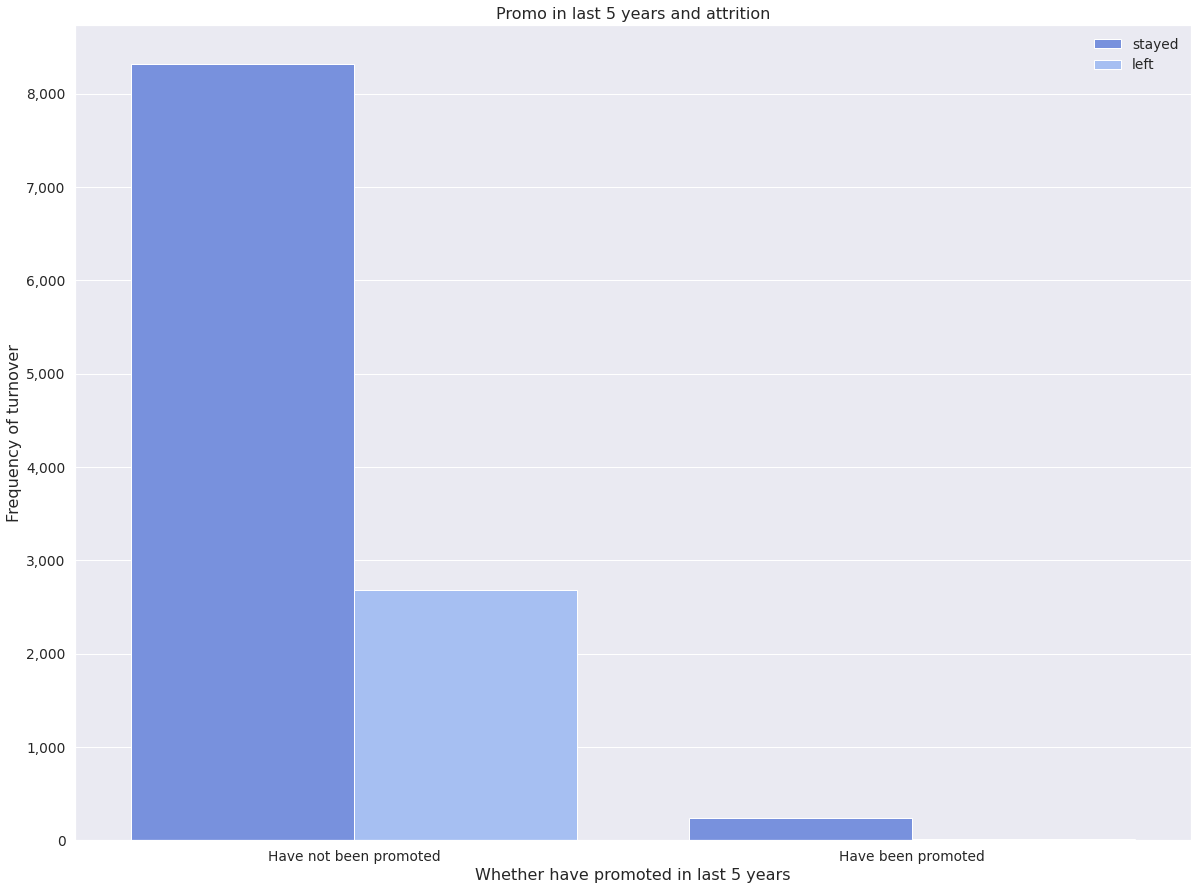

In [95]:
# Make a countplot.
ax = sns.countplot(x = 'promo_in_last_5_years', hue = 'attrit', data = attrition_df, palette = sns.color_palette('coolwarm'))

# Format legend.
plt.legend(['stayed', 'left'])

# Format axes
fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

# Set x and y lable name and the title.
ax.set_xlabel('Whether have promoted in last 5 years', fontsize = 16)
ax.set_ylabel('Frequency of turnover', fontsize = 16)
ax.set_title('Promo in last 5 years and attrition', fontsize = 16)

plt.xticks((0, 1), ['Have not been promoted', "Have been promoted"])

Most of the employees who did not get promotion in last 5 years.

Although just a few of employees who have been promoted, the attrition frequenct is less when employees got promotion.

# **Part 3 - Determine the causes for attrition by logistic regression**

## Convert 2 categorical variables, 'dept' and 'salary' to dummy variables


In [0]:
cat_vars = ['dept', 'salary']
for var in cat_vars:
    cat_list = 'var' + '_' + var
    cat_list = pd.get_dummies(attrition_df[var], prefix = var)
    attrition_df = attrition_df.join(cat_list)

In [97]:
attrition_df.drop(['dept', 'salary'], axis=1, inplace=True)
attrition_df.columns.values

array(['employee_satisfaction', 'last_performance_rating', 'workload',
       'avg_montly_hours', 'tenure_years', 'ergo_issues', 'attrit',
       'promo_in_last_5_years', 'dept_ADMIN', 'dept_EXEC', 'dept_FIN',
       'dept_HR', 'dept_IS', 'dept_MKT', 'dept_PM', 'dept_RTD',
       'dept_SALES', 'dept_TECH', 'salary_LARGE', 'salary_MEDIUM',
       'salary_SMALL'], dtype=object)

In [98]:
attrition_df.head(1)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept_ADMIN,dept_EXEC,dept_FIN,dept_HR,dept_IS,dept_MKT,dept_PM,dept_RTD,dept_SALES,dept_TECH,salary_LARGE,salary_MEDIUM,salary_SMALL
0,0.82,0.97,3,244,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


## Logistic regression model development

In [99]:
# Set X and y. 

X = attrition_df.drop('attrit', axis=1)
y = attrition_df['attrit']

# Train and test sets: 70% and 30% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(7874, 20) (7874,)
(3375, 20) (3375,)


In [100]:
# Initialize logistic regressor
model = LogisticRegression(C = 3.2, max_iter = 1000)

# Fit the model
model.fit(X_train, y_train.values.ravel())

LogisticRegression(C=3.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
# Let's score the model
print('Accuracy score: ', model.score(X_test, y_test).round(3))

Accuracy score:  0.792


In [102]:
# Check the bias 

print('Bias: ', model.intercept_)

Bias:  [-0.38467759]


In [103]:
# Get predictions for the test set.
# Each value corresponds to a transaction outcome of 0 (no) or 1 (yes)

model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

## Rank the welght value to see the importance (influence) of each feature (by absolute value)

In [104]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Features']

coeff_df['Coefficient'] = pd.Series(model.coef_[0])

coeff_df.sort_values(by = 'Coefficient', ascending = False)

coeff_df.iloc[coeff_df['Coefficient'].abs().argsort()[::-1]].round(4)

,Features,Coefficient
0,employee_satisfaction,-4.0793
5,ergo_issues,-1.5531
6,promo_in_last_5_years,-1.5005
17,salary_LARGE,-1.2400
19,salary_SMALL,0.7074
1,last_performance_rating,0.6994
8,dept_EXEC,-0.5254
14,dept_RTD,-0.5229
2,workload,-0.2857
4,tenure_years,0.2781


## **Summary on the the causes for attrition**

The top 5 reasons for attrion are below.

 1. employee_satisfaction
 2. ergo_issues
 3. promo_in_last_5_years
 4. salary (salary_LARGE and salary_SMALL are considered as same feature)
 5. last_performance_rating

# **Part 4 - Assess the performance of my model**

Since I am dealing with inbalanced dataset, the accuracy is not the best metric to use.

I would like to look at the following performance measures that can give more insight into the accuracy of the model than traditional classification accuracy:

- Confusion Matrix: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
- Precision: A measure of a classifiers exactness.
- Recall: A measure of a classifiers completeness
- F1 Score (or F-score): A weighted average of precision and recall.
- ROC Curves: like precision and recall, accuracy is divided into sensitivity and specificity and models can be chosen based on the balance thresholds of these values.

*Reference*

- 8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

## 1. Accuracy score

In [105]:
acc = model.score(X_test, y_test).round(3) * 100
print('Accuracy score: ', acc, str('%'))

Accuracy score:  79.2 %


## 2. F1 score, precision and recall value

In [106]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87      2596
           1       0.58      0.35      0.44       779

    accuracy                           0.79      3375
   macro avg       0.70      0.64      0.65      3375
weighted avg       0.77      0.79      0.77      3375



## 3. Visualize confusion matrix by heatmap

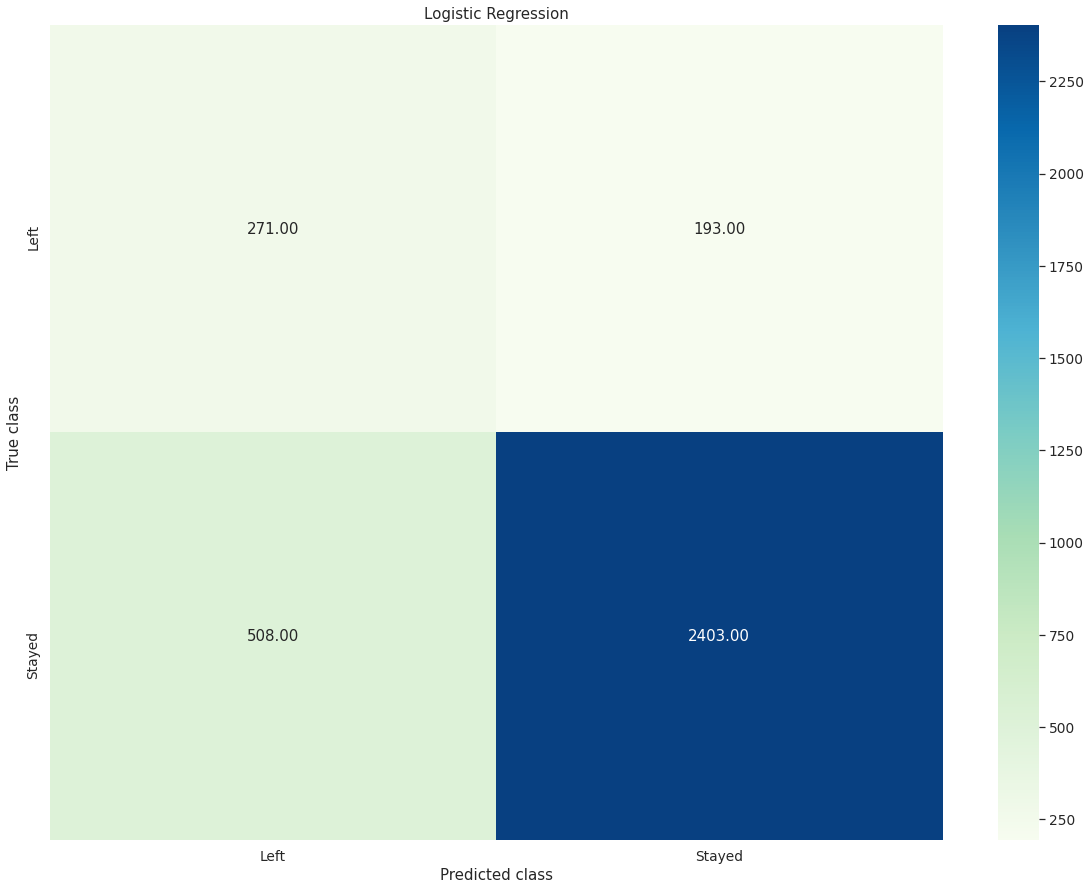

In [107]:
logreg_y_pred = model.predict(X_test)
logreg_cm = metrics.confusion_matrix(logreg_y_pred, y_test, [1,0])
sns.heatmap(logreg_cm, annot=True, fmt='.2f', xticklabels = ['Left', 'Stayed'] , yticklabels = ['Left', 'Stayed'], cmap = 'GnBu')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logistic Regression')
plt.savefig('logistic_regression')

## 4. Visualize ROC curve

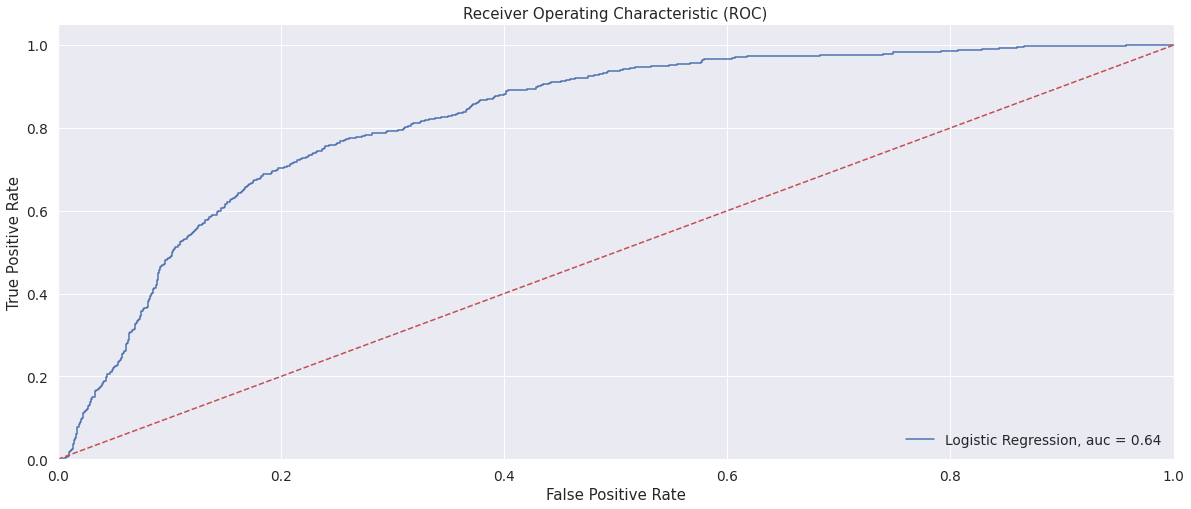

In [108]:
# Set the figure size. 
rcParams['figure.figsize'] = (20, 8)

# Compute ROC value. 
auc = roc_auc_score(y_test, model.predict(X_test)).round(2)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

# Visualization. 
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression, auc = '+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

The receiver operating characteristic (ROC) curve is a common tool used with binary classifiers. 

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).



## **Part 5 - Generate 5 sample predictions for input values of my choosing**

In [109]:
# Generate 5 samples for each variable. 
sample = {'employee_satisfaction': [0.45, 0.65, 0.3, 0.8, 0.4], 'last_performance_rating': [0.5, 0.4, 0.8, 0.65, 0.84], 'ergo_issues': [1, 0, 1, 1, 0], 
          'promo_in_last_5_years': [1, 0, 1, 1, 1], 'salary_LARGE': [0, 1, 0, 1, 0], 'salary_SMALL': [1, 0, 1, 0, 1], 'salary_MIDDLE': [0, 0, 0, 0, 0], 
          'dept_EXEC': [1, 0, 0, 1, 1], 'dept_ADMIN': [0, 0, 0, 0, 0], 'dept_EXEC': [0, 1, 0, 0, 0], 'dept_FIN': [0, 0, 0, 0, 0], 
          'dept_HR': [0, 0, 1, 0, 0], 'dept_IS': [0, 0, 0, 0, 0], 'dept_MKT': [0, 0, 0, 0, 0], 'dept_PM': [0, 0, 0, 0, 0], 'dept_RTD': [0, 0, 0, 0, 0], 
          'dept_SALES': [0, 0, 0, 0, 0], 'dept_TECH': [0, 0, 0, 0, 0], 'dept_PM': [0, 0, 0, 0, 0], 'workload': [6, 5, 7, 4, 3], 
          'avg_montly_hours': [250, 200, 160, 260, 200], 'tenure_years': [3, 4, 5, 5, 7]}

# Convert dict to dataframe.
arbitrary_values = pd.DataFrame(data = sample)
arbitrary_values

,employee_satisfaction,last_performance_rating,ergo_issues,promo_in_last_5_years,salary_LARGE,salary_SMALL,salary_MIDDLE,dept_EXEC,dept_ADMIN,dept_FIN,dept_HR,dept_IS,dept_MKT,dept_PM,dept_RTD,dept_SALES,dept_TECH,workload,avg_montly_hours,tenure_years
0,0.45,0.50,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,6,250,3
1,0.65,0.40,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,5,200,4
2,0.30,0.80,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,7,160,5
3,0.80,0.65,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4,260,5
4,0.40,0.84,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,3,200,7


In [110]:
# Now, let's use the model to predict attrition for arbitrary values

arbitrary_values.join(pd.DataFrame(model.predict(arbitrary_values), columns = {'Prediction'}).set_index([pd.Index(arbitrary_values.index)]))

,employee_satisfaction,last_performance_rating,ergo_issues,promo_in_last_5_years,salary_LARGE,salary_SMALL,salary_MIDDLE,dept_EXEC,dept_ADMIN,dept_FIN,dept_HR,dept_IS,dept_MKT,dept_PM,dept_RTD,dept_SALES,dept_TECH,workload,avg_montly_hours,tenure_years,Prediction
0,0.45,0.50,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,6,250,3,1
1,0.65,0.40,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,5,200,4,1
2,0.30,0.80,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,7,160,5,1
3,0.80,0.65,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4,260,5,1
4,0.40,0.84,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,3,200,7,1


In [111]:
# Create a data structure that contains the probabilities for a broad range.

exhaustive_data_df = pd.DataFrame(arbitrary_values)
prediction_df2 = pd.DataFrame(model.predict(exhaustive_data_df), columns = {'Prediction'}).set_index([pd.Index(exhaustive_data_df.index)])
probability_df2 = pd.DataFrame(model.predict_proba(exhaustive_data_df)).set_index([pd.Index(exhaustive_data_df.index)])
all_together_df2 = exhaustive_data_df.join(prediction_df2).join(probability_df2)
all_together_df2

,employee_satisfaction,last_performance_rating,ergo_issues,promo_in_last_5_years,salary_LARGE,salary_SMALL,salary_MIDDLE,dept_EXEC,dept_ADMIN,dept_FIN,dept_HR,dept_IS,dept_MKT,dept_PM,dept_RTD,dept_SALES,dept_TECH,workload,avg_montly_hours,tenure_years,Prediction,0,1
0,0.45,0.50,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,6,250,3,1,2.664535e-15,1.0
1,0.65,0.40,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,5,200,4,1,4.927170e-13,1.0
2,0.30,0.80,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,7,160,5,1,3.371769e-09,1.0
3,0.80,0.65,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4,260,5,1,0.000000e+00,1.0
4,0.40,0.84,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,3,200,7,1,8.881784e-15,1.0


In my sample, the logistic regression model predicts all 5 employees are likely to quit. 